In [ ]:
# Installation of the libraries which we'll use: HuggingFace Transformers, Datasets and Evaluate
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.8 MB/s eta 0:00:00


In [ ]:
# Installation of the paraphrase library
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

from parrot import Parrot

  Cloning https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to /tmp/pip-req-build-_47aefip
  Running command git clone --filter=blob:none --quiet https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git /tmp/pip-req-build-_47aefip
  Resolved https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git to commit 720a87a1ee557d8ed8d9a021adbdd1dd5616c5f9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

from tqdm import trange
import pandas as pd
import numpy as np

from random import sample

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the seed for random generation
seed = 42
torch.manual_seed(seed)

In [ ]:
root = "https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/dataset/augmented_dataset.csv"

df = pd.read_csv(root, sep = ';')
label_mapping = {'get_smells': 0, 'get_smells_date': 1, 'report': 2, 'info': 3}
df['intent'] = df['intent'].map(label_mapping)

In [ ]:
def paraphrase(phrase):
    para_phrases = parrot.augment(input_phrase=phrase, use_gpu=False)
    if para_phrases == None:
      return None
    else:
      return para_phrases[0][0]

In [ ]:
def remove_duplicate_rows(df, col1, col2):
    # Compare the values of col1 and col2 columns
    duplicates = df[col1].str.lower().str.strip().eq(df[col2].str.lower().str.strip())

    # Remove duplicate rows
    df_filtered = df[~duplicates]

    return df_filtered

In [ ]:
def plot(intent):
  # Convert NumPy array to a Pandas Series object
  intent_series = pd.Series(intent)

  # Creates a bar graph for counting the occurrences of each unique value
  intent_series.value_counts().plot(kind='bar')

In [ ]:
def input_test_weighted_predictions(df, col_original, col_paraphrased, col_intent, model):

  correct_get_smells, correct_get_smells_date, correct_report, correct_info=0, 0, 0, 0

  total_get_smells, total_get_smells_date, total_report, total_info=0, 0, 0, 0
  for index, row in df.iterrows():
    request_original=row[col_original]
    request=row[col_paraphrased]
    intent=row[col_intent]

    request_ids = tokenizer.encode_plus(
                            request,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_ids = torch.clone(request_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = torch.softmax(output.logits, dim=1)
    confidence = predictions.max(dim=1).values.detach().cpu().numpy()
    predicted_class = predictions.argmax(dim=1).flatten().cpu().numpy()



    request_original_ids = tokenizer.encode_plus(
                            request_original,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_tensors = 'pt'
                      )

    input_original_ids = torch.clone(request_original_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output_original = model(input_original_ids)

    predictions_original = torch.softmax(output_original.logits, dim=1)
    confidence_original = predictions_original.max(dim=1).values.detach().cpu().numpy()
    predicted_original_class = predictions_original.argmax(dim=1).flatten().cpu().numpy()

    if confidence < 0.55:
      print("NOT ENOUGH CONFIDENCE TO ANSWER")

    for label, index in label_mapping.items():
        if index == predicted_class:
            predicted_label = label
            break
    for label, index in label_mapping.items():
        if index == predicted_original_class:
            predicted_original_label = label
            break

    if intent == 0:
      total_get_smells=total_get_smells+1
      intent_text="get_smells"
      if "get_smells" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_get_smells=correct_get_smells+1
    elif intent == 1:
      intent_text="get_smells_date"
      total_get_smells_date=total_get_smells_date+1
      if "get_smells_date" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_get_smells_date=correct_get_smells_date+1
    elif intent == 2:
      intent_text="report"
      total_report=total_report+1
      if "report" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_report=correct_report+1
    elif intent == 3:
      intent_text="info"
      total_info=total_info+1
      if "info" == predicted_label == predicted_original_label and confidence_original-confidence < 0.2:
          correct_info=correct_info+1


    print("Correct class: " + intent_text + " --- Predicted class: " + str(predicted_label) + " --- " + request+"\n Confidence: "+str(confidence)+" --- Difference between original confidence and paraphrased confidence: "+str(confidence_original-confidence)+"\n")



  percentage_get_smells=correct_get_smells/total_get_smells
  percentage_get_smells_date=correct_get_smells_date/total_get_smells_date
  percentage_report=correct_report/total_report
  percentage_info=correct_info/total_info
  print("Percentage get_smells: "+ str(percentage_get_smells))
  print("Percentage get_smells_date: "+ str(percentage_get_smells_date))
  print("Percentage report: "+ str(percentage_report))
  print("Percentage info: "+ str(percentage_info))
  sum_of_requests= total_get_smells + total_get_smells_date + total_report + total_info
  weighted_average=((percentage_get_smells*total_get_smells)+(percentage_get_smells_date*total_get_smells_date)+(percentage_report*total_report)+(percentage_info*total_info))/(sum_of_requests)
  print("Weighted average: "+str(weighted_average))

In [ ]:
# Select 30% of rows randomly
n_samples = int(len(df) * 0.3)
selected_rows = sample(range(len(df)), n_samples)

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")

df_test = pd.DataFrame(columns=['original_request', 'paraphrased_request', 'intent'])

# Apply paraphrasing and metamorphosis on selected rows
for index, row in df.iloc[selected_rows].iterrows():
    # Get the original request from the dataset
    original_request = row['request']

    print(index, original_request)

    # Apply paraphrasing
    paraphrased_request = paraphrase(original_request)
    print("PARAPHRASE:", paraphrased_request)

    if paraphrased_request != None:
      df_test = df_test.append({'original_request': original_request,
                                'paraphrased_request': paraphrased_request,
                                'intent': row['intent']}, ignore_index=True)

print(df_test.head())
df_test.to_csv("./df_input_testing", sep=";", index=False)

In [ ]:
df_test = pd.read_csv("https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/dataset/df_input_testing_eng.csv", sep=";")

# Call the function to remove duplicate or similar rows
df_test = remove_duplicate_rows(df_test, 'original_request', 'paraphrased_request')

# Print the resulting DataFrame
df_test.head()

,original_request,paraphrased_request,intent
0,What's are the community smells in the LINK pr...,what community smells in the link project?,0
1,"Hey CADOCS, what kind of community smells can ...",tell me the smell of community?,3
4,"hey CADOCS, can you show me some informations ...",tell me the information on the smells of the c...,3
5,"I, tell me somethings about your last execution",i tell you about your last execution,2
6,Hey CADOCS cfn you please tell me more about t...,can you tell me the community smells that you ...,3


In [ ]:
request = df_test.paraphrased_request.values
intent = df_test.intent.values

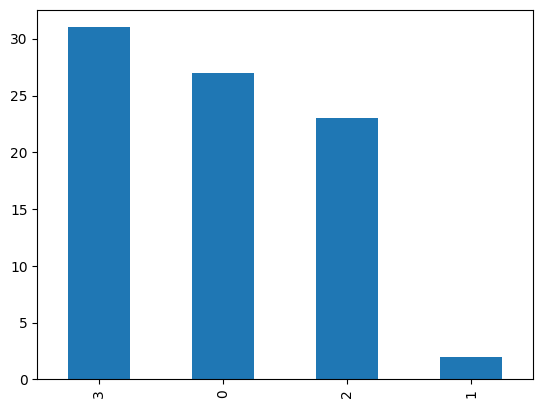

In [ ]:
plot(intent)

In [ ]:
# Load the metrics
import evaluate

accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load('f1')
mcc_metric = evaluate.load('matthews_correlation')

# Compute of metrics
def compute_metrics(preds, label_ids):
  accuracy = accuracy_metric.compute(predictions=preds, references=label_ids)['accuracy']
  precision = precision_metric.compute(predictions=preds, references=label_ids, average=None)['precision']
  precision_w = precision_metric.compute(predictions=preds, references=label_ids, average='weighted')['precision']
  recall = recall_metric.compute(predictions=preds, references=label_ids, average=None)['recall']
  recall_w = recall_metric.compute(predictions=preds, references=label_ids, average='weighted')['recall']
  f1 = f1_metric.compute(predictions=preds, references=label_ids, average=None)['f1']
  f1_w = f1_metric.compute(predictions=preds, references=label_ids, average='weighted')['f1']
  mcc = mcc_metric.compute(predictions=preds, references=label_ids)['matthews_correlation']

  return accuracy, precision, precision_w, recall, recall_w, f1, f1_w, mcc

In [ ]:
# Tokenizer of RoBERTa
tokenizer = RobertaTokenizer.from_pretrained(
    'roberta-base',
    do_lower_case = True
)

def get_metrics(df, col_req, col_intent, model):
  preds = []

  for index, row in df.iterrows():
    request_ids = tokenizer.encode_plus(
                              row[col_req],
                              add_special_tokens = True,
                              max_length = 32,
                              pad_to_max_length = True,
                              return_attention_mask = True,
                              return_tensors = 'pt'
                        )

    input_ids = torch.clone(request_ids['input_ids']).detach().to(model.device)

    with torch.no_grad():
        output = model(input_ids)

    predictions = torch.softmax(output.logits, dim=1)
    confidence = predictions.max(dim=1).values.detach().cpu().numpy()
    predicted_class = predictions.argmax(dim=1).flatten().cpu().numpy()

    preds.append(predicted_class[0])

  # Calculate test metrics
  test_accuracy, test_precision, test_precision_w, test_recall, test_recall_w, test_f1, test_f1_w, test_mcc = compute_metrics(preds, df[col_intent].values)

  print('- Test Accuracy: {:.4f}'.format(test_accuracy))

  print('\n- Test Precision weighted: {:.4f}'.format(test_precision_w))
  print('\t- Test Precision [class get_smell]: {:.4f}'.format(test_precision[0]))
  print('\t- Test Precision [class get_smell_date]: {:.4f}'.format(test_precision[1]))
  print('\t- Test Precision [class report]: {:.4f}'.format(test_precision[2]))
  print('\t- Test Precision [class info]: {:.4f}'.format(test_precision[3]))

  print('\n- Test Recall weighted: {:.4f}'.format(test_recall_w))
  print('\t- Test Recall [class get_smell]: {:.4f}'.format(test_recall[0]))
  print('\t- Test Recall [class get_smell_date]: {:.4f}'.format(test_recall[1]))
  print('\t- Test Recall [class report]: {:.4f}'.format(test_recall[2]))
  print('\t- Test Recall [class info]: {:.4f}'.format(test_recall[3]))

  print('\n- Test F1 weighted: {:.4f}'.format(test_f1_w))
  print('\t- Test F1 [class get_smell]: {:.4f}'.format(test_f1[0]))
  print('\t- Test F1 [class get_smell_date]: {:.4f}'.format(test_f1[1]))
  print('\t- Test F1 [class report]: {:.4f}'.format(test_f1[2]))
  print('\t- Test F1 [class info]: {:.4f}'.format(test_f1[2]))

  print('\n- Test MCC: {:.4f}\n'.format(test_mcc))

In [ ]:
# Load the model
model = RobertaForSequenceClassification.from_pretrained("alfcan/CADOCS_NLU_eng")

In [ ]:
get_metrics(df_test, "paraphrased_request", "intent", model)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


- Test Accuracy: 1.0000

- Test Precision weighted: 1.0000
	- Test Precision [class get_smell]: 1.0000
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 1.0000
	- Test Precision [class info]: 1.0000

- Test Recall weighted: 1.0000
	- Test Recall [class get_smell]: 1.0000
	- Test Recall [class get_smell_date]: 1.0000
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 1.0000
	- Test F1 [class get_smell]: 1.0000
	- Test F1 [class get_smell_date]: 1.0000
	- Test F1 [class report]: 1.0000
	- Test F1 [class info]: 1.0000

- Test MCC: 1.0000



In [ ]:
input_test_weighted_predictions(df_test, "original_request", "paraphrased_request", "intent", model)

Correct class: get_smells --- Predicted class: get_smells --- what community smells in the link project?
 Confidence: [0.99869066] --- Difference between original confidence and paraphrased confidence: [0.00010097]

Correct class: info --- Predicted class: info --- tell me the smell of community?
 Confidence: [0.9987709] --- Difference between original confidence and paraphrased confidence: [0.00025719]

Correct class: info --- Predicted class: info --- tell me the information on the smells of the community that you can detect only manually?
 Confidence: [0.99892247] --- Difference between original confidence and paraphrased confidence: [0.00019866]

Correct class: report --- Predicted class: report --- i tell you about your last execution
 Confidence: [0.9989188] --- Difference between original confidence and paraphrased confidence: [0.00035864]

Correct class: info --- Predicted class: info --- can you tell me the community smells that you can detect?
 Confidence: [0.9991279] --- Dif

In [ ]:
dfParaphrased = pd.read_csv("https://raw.githubusercontent.com/alfcan/CADOCS_NLU_Model/dev/dataset/paraphrased_dataset.csv", sep = ';', names=["original", "paraphrase", "intent"])

dfParaphrased['intent'] = dfParaphrased['intent'].map(label_mapping)

dfParaphrased.head()

,original,paraphrase,intent
0,"Hey CADOCS, tell which community smells are pr...","Hey CADOCS, tell which community smells are pr...",0
1,CADOCS can you tell which community smells ar...,how can you tell if your link contains any com...,0
2,CADOCS can you tell which community smells ar...,can cadocs tell me what community smells are p...,0
3,CADOCS can you tell which community smells ar...,can cadocs tell me which community smells are ...,0
4,I would like to know what are the community sm...,i'd like to know what smells the community has...,0


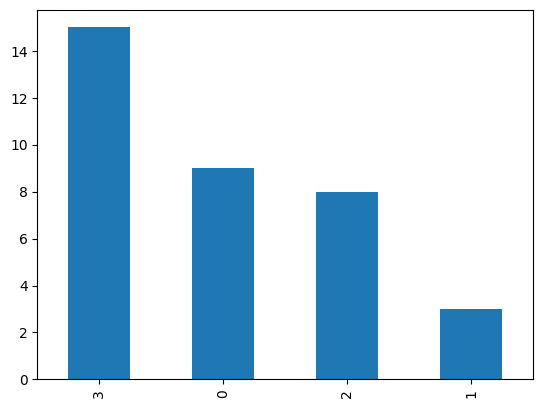

In [ ]:
plot(dfParaphrased['intent'])

In [ ]:
get_metrics(dfParaphrased, "paraphrase", "intent", model)

- Test Accuracy: 0.9714

- Test Precision weighted: 0.9732
	- Test Precision [class get_smell]: 1.0000
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 1.0000
	- Test Precision [class info]: 0.9375

- Test Recall weighted: 0.9714
	- Test Recall [class get_smell]: 0.8889
	- Test Recall [class get_smell_date]: 1.0000
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 0.9710
	- Test F1 [class get_smell]: 0.9412
	- Test F1 [class get_smell_date]: 1.0000
	- Test F1 [class report]: 1.0000
	- Test F1 [class info]: 1.0000

- Test MCC: 0.9595



In [ ]:
input_test_weighted_predictions(dfParaphrased, "original", "paraphrase", "intent", model)

Correct class: get_smells --- Predicted class: get_smells --- Hey CADOCS, tell which community smells are present in the repository LINK ?
 Confidence: [0.9987966] --- Difference between original confidence and paraphrased confidence: [0.]

Correct class: get_smells --- Predicted class: get_smells --- how can you tell if your link contains any community smells?
 Confidence: [0.85550034] --- Difference between original confidence and paraphrased confidence: [0.14321423]

Correct class: get_smells --- Predicted class: get_smells --- can cadocs tell me what community smells are present in the link?
 Confidence: [0.99852055] --- Difference between original confidence and paraphrased confidence: [0.00019401]

Correct class: get_smells --- Predicted class: get_smells --- can cadocs tell me which community smells are present in the link?
 Confidence: [0.9985897] --- Difference between original confidence and paraphrased confidence: [0.00012487]

Correct class: get_smells --- Predicted class: 

# Results of the adestracted model with the old dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/Shareddrives/CADOCS_Transformers/models/model_old_dataset.pth"

In [ ]:
model_old = torch.load(PATH, map_location=torch.device('cpu'))

In [ ]:
get_metrics(df_test, "paraphrased_request", "intent", model_old)

- Test Accuracy: 0.9880

- Test Precision weighted: 0.9883
	- Test Precision [class get_smell]: 1.0000
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 1.0000
	- Test Precision [class info]: 0.9688

- Test Recall weighted: 0.9880
	- Test Recall [class get_smell]: 1.0000
	- Test Recall [class get_smell_date]: 1.0000
	- Test Recall [class report]: 0.9565
	- Test Recall [class info]: 1.0000

- Test F1 weighted: 0.9879
	- Test F1 [class get_smell]: 1.0000
	- Test F1 [class get_smell_date]: 1.0000
	- Test F1 [class report]: 0.9778
	- Test F1 [class info]: 0.9778

- Test MCC: 0.9824



In [ ]:
input_test_weighted_predictions(df_test, "original_request", "paraphrased_request", "intent", model_old)

Correct class: get_smells --- Predicted class: get_smells --- what community smells in the link project?
 Confidence: [0.9275623] --- Difference between original confidence and paraphrased confidence: [0.03558606]

Correct class: info --- Predicted class: info --- tell me the smell of community?
 Confidence: [0.681857] --- Difference between original confidence and paraphrased confidence: [-0.01931936]

Correct class: info --- Predicted class: info --- tell me the information on the smells of the community that you can detect only manually?
 Confidence: [0.956015] --- Difference between original confidence and paraphrased confidence: [-0.06876469]

Correct class: report --- Predicted class: report --- i tell you about your last execution
 Confidence: [0.98307204] --- Difference between original confidence and paraphrased confidence: [-0.00780445]

Correct class: info --- Predicted class: info --- can you tell me the community smells that you can detect?
 Confidence: [0.98200905] --- Di

In [ ]:
get_metrics(dfParaphrased, "paraphrase", "intent", model_old)

- Test Accuracy: 0.9429

- Test Precision weighted: 0.9429
	- Test Precision [class get_smell]: 0.8889
	- Test Precision [class get_smell_date]: 1.0000
	- Test Precision [class report]: 1.0000
	- Test Precision [class info]: 0.9333

- Test Recall weighted: 0.9429
	- Test Recall [class get_smell]: 0.8889
	- Test Recall [class get_smell_date]: 1.0000
	- Test Recall [class report]: 1.0000
	- Test Recall [class info]: 0.9333

- Test F1 weighted: 0.9429
	- Test F1 [class get_smell]: 0.8889
	- Test F1 [class get_smell_date]: 1.0000
	- Test F1 [class report]: 1.0000
	- Test F1 [class info]: 1.0000

- Test MCC: 0.9173



In [ ]:
input_test_weighted_predictions(dfParaphrased, "original", "paraphrase", "intent", model_old)

Correct class: get_smells --- Predicted class: get_smells --- Hey CADOCS, tell which community smells are present in the repository LINK ?
 Confidence: [0.966876] --- Difference between original confidence and paraphrased confidence: [0.]

Correct class: get_smells --- Predicted class: info --- how can you tell if your link contains any community smells?
 Confidence: [0.60836947] --- Difference between original confidence and paraphrased confidence: [0.34001118]

Correct class: get_smells --- Predicted class: get_smells --- can cadocs tell me what community smells are present in the link?
 Confidence: [0.88553536] --- Difference between original confidence and paraphrased confidence: [0.06284529]

Correct class: get_smells --- Predicted class: get_smells --- can cadocs tell me which community smells are present in the link?
 Confidence: [0.9095049] --- Difference between original confidence and paraphrased confidence: [0.03887576]

Correct class: get_smells --- Predicted class: get_sme